In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/04/14 15:32:12 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/04/14 15:32:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/14 15:32:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/14 15:32:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
base_path = "/data/saturation/thesis_run_20240130"
study_region_size = 4000
r_stat = 5
study_region_padding = int(study_region_size * 0.125)

In [5]:
configs_df = create_configs_df(read_configs(base_path, spark))
configs_pd = configs_df.toPandas()

In [6]:
configs_pd[configs_pd.slope.between(2.7, 2.8)].sort_values("slope")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
9207,1.450640,0.317497,9.230911,204,2.700036
987,1.164508,0.264163,12.653650,2419,2.700196
3774,1.260481,0.474409,14.173195,725,2.700208
8341,1.533356,0.402474,6.008638,6930,2.700491
7921,1.419263,0.372001,7.509564,6277,2.700559
...,...,...,...,...,...
9307,1.869408,0.430136,9.830555,7078,2.799143
5446,1.344546,0.699171,8.976379,669,2.799165
5417,1.785421,0.258385,13.133549,5407,2.799456
426,1.360024,0.357949,10.322456,9267,2.799780


In [7]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config_*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

## Example CSFD

estimated slope=-2.676, sigma=0.054


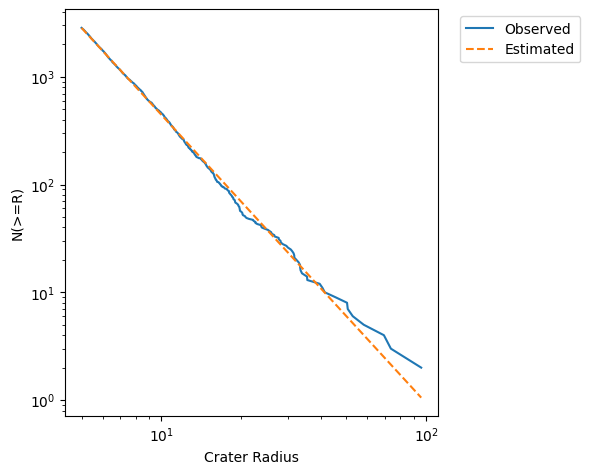

In [8]:
# Steep slope, 2.7
simulation_id = 6930
target_n_craters_added_in_study_region = 3000
est_saturation_n = 40

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding,
    spark
)   

estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                   state.radius.min(),
                                                   est_saturation_n)
intercept = estimate_intercept(state.radius[state.radius < est_saturation_n], estimated_slope)
print(f"estimated slope={estimated_slope:.3f}, sigma={sigma:.3f}")
plot_sfds(state, -estimated_slope, intercept=intercept)

In [ ]:
est_saturation_n = 40

# estimated_production_slope, estimated_production_sigma = estimate_cumulative_slope(state.radius,
#                                                                                    est_saturation_n,
#                                                                                    state.radius.max())
stimated_production_slope = 2.7
estimated_production_intercept = estimate_intercept(state.radius[state.radius > est_saturation_n], estimated_production_slope)
print(f"estimated slope={estimated_production_slope:.3f}, sigma={estimated_production_sigma:.3f}")

plot_sfds(state, -estimated_production_slope, intercept=estimated_production_intercept)

In [ ]:
radii = state.radius[state.radius.between(5, 50)].sort_values()

# Track min and max radii
min_radius = radii.min()
max_radius = radii.max()

plt.plot(radii, range(len(radii) + 1, 1, -1), label="Observed")
plt.xlabel("$R$")
plt.ylabel("$N(\geq R)$")

expected = intercept * radii ** estimated_slope
plt.plot(radii, expected, label="Estimated Slope", ls="--")

expected = estimated_production_intercept * radii ** estimated_production_slope
plt.plot(radii, expected, label="Production Slope", ls="dotted")

plt.subplots_adjust(right=0.7)
plt.tight_layout(rect=[0, 0, 0.75, 1])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
state

In [ ]:
# Test for 1000 different sims
target_n_craters_added_in_study_region = 100000

sim_ids_and_slopes = configs_pd.sample(1000)[["slope", "simulation_id"]]

results_saturated = []
for row in sim_ids_and_slopes.itertuples():
    slope = row.slope
    simulation_id = row.simulation_id

    sim_name = configs_dict[simulation_id]["simulation_name"]
    sim_path = f"{base_path}/{sim_name}"

    stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
    craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")
    
    state = get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        target_n_craters_added_in_study_region,
        study_region_size,
        study_region_padding,
        spark
    )   

    estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                       state.radius.min(),
                                                       state.radius.max())
    intercept = estimate_intercept(state.radius, estimated_slope)
    results_saturated.append([simulation_id, slope, estimated_slope, sigma, intercept])

    if len(results_saturated) % 50 == 0:
        print(f"id={simulation_id}, slope={slope:.2f}, est slope={estimated_slope:.2f}")

In [ ]:
# Test for 1000 different sims, 
target_n_craters_added_in_study_region = 500

sim_ids_and_slopes = configs_pd.sample(1000)[["slope", "simulation_id"]]

results_not_saturated = []
for row in sim_ids_and_slopes.itertuples():
    slope = row.slope
    simulation_id = row.simulation_id

    sim_name = configs_dict[simulation_id]["simulation_name"]
    sim_path = f"{base_path}/{sim_name}"

    stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
    craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")
    
    state = get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        target_n_craters_added_in_study_region,
        study_region_size,
        study_region_padding,
        spark
    )   

    estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                       state.radius.min(),
                                                       state.radius.quantile(0.75))
    intercept = estimate_intercept(state.radius, estimated_slope)
    results_not_saturated.append([simulation_id, slope, estimated_slope, sigma, intercept])

    if len(results_not_saturated) % 50 == 0:
        print(f"id={simulation_id}, slope={slope:.2f}, est slope={estimated_slope:.2f}, sigma={sigma:.3f}")

In [ ]:
# Test for 1000 different sims, 
target_n_craters_added_in_study_region = 1000

sim_ids_and_slopes = configs_pd.sample(1000)[["slope", "simulation_id"]]

results_not_saturated2 = []
for row in sim_ids_and_slopes.itertuples():
    slope = row.slope
    simulation_id = row.simulation_id

    sim_name = configs_dict[simulation_id]["simulation_name"]
    sim_path = f"{base_path}/{sim_name}"

    stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
    craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")
    
    state = get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        target_n_craters_added_in_study_region,
        study_region_size,
        study_region_padding,
        spark
    )   

    estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                       state.radius.min(),
                                                       state.radius.quantile(0.75))
    intercept = estimate_intercept(state.radius, estimated_slope)
    results_not_saturated2.append([simulation_id, slope, estimated_slope, sigma, intercept])

    if len(results_not_saturated2) % 50 == 0:
        print(f"id={simulation_id}, slope={slope:.2f}, est slope={estimated_slope:.2f}, sigma={sigma:.3f}")

In [ ]:
simulation_id = 5407
sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

In [ ]:
stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

target_n_craters_added_in_study_region = 10000

state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding,
    spark
)   

plot_sfds(sandblasting_5, slope, intercept=6e7)

In [ ]:
state.describe()

In [ ]:
calculate_areal_density(state, study_region_size, study_region_padding, 5.0)

In [ ]:
cutoff_radius = 5000
s = state[state.radius < cutoff_radius]
slope, sigma = estimate_cumulative_slope(s.radius,
                                         s.radius.min(),
                                         s.radius.max())
intercept = estimate_intercept(s.radius, slope)
slope, sigma, intercept

In [ ]:
plot_sfds(state, -slope, intercept=intercept)

In [ ]:
plot_terrain(state)

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 1000

state_8296_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 500

state_8296_500 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 360000

state_8296_360000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 100000

state_8296_100000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 7099
target_n_craters_added_in_study_region = 1000

state_7099_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 4458
target_n_craters_added_in_study_region = 1000

state_4458_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 7230
target_n_craters_added_in_study_region = 1000

state_7230_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 7230
target_n_craters_added_in_study_region = 100000

state_7230_100000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
plot_terrain(state_8296_100000)

In [ ]:
calculate_areal_density(state_8296_1000, study_region_size, study_region_padding, r_stat)

In [ ]:
stats_df = spark.read.parquet(f"/data/saturation/discrete_tests/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/discrete_tests/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/discrete_tests/*/crater_removals_*.parquet")

simulation_id = 3
target_n_craters_added_in_study_region = 8000000

state_discrete_two_levels_slope_6 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
state = state_discrete_two_levels_slope_6
np.where(state.radius == 5, 1, 0).sum() / state.shape[0]

In [ ]:
state = state_discrete_two_levels_slope_6
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=1000.0)

In [ ]:
stats_df = spark.read.parquet(f"/data/saturation/discrete_tests/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/discrete_tests/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/discrete_tests/*/crater_removals_*.parquet")

simulation_id = 2
target_n_craters_added_in_study_region = 8000000

state_discrete_three_levels_6_mult = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
state = state_discrete_three_levels_6_mult
np.where(state.radius == 5, 1, 0).sum() / state.shape[0]

In [ ]:
state = state_discrete_three_levels_6_mult
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
stats_df = spark.read.parquet(f"/data/saturation/deep_test/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/deep_test/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/deep_test/*/crater_removals_*.parquet")

simulation_id = 3
target_n_craters_added_in_study_region = 3000000

state_3_3000000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"/data/saturation/deep_test/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/deep_test/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/deep_test/*/crater_removals_*.parquet")

simulation_id = 4
target_n_craters_added_in_study_region = 30000000

state_4_30000000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"/data/saturation/deep_test/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/deep_test/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/deep_test/*/crater_removals_*.parquet")

simulation_id = 6
target_n_craters_added_in_study_region = 3000

state_6_3000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
stats_df = spark.read.parquet(f"/data/saturation/sandblasting_tests/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/sandblasting_tests/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/sandblasting_tests/*/crater_removals_*.parquet")

simulation_id = 5
target_n_craters_added_in_study_region = 30000000

sandblasting_5 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [ ]:
state = sandblasting_5
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
slope = 6.1
plot_sfds(sandblasting_5, slope, intercept=6e7)

In [ ]:
slope = 8.1
plot_sfds(state_6_3000, slope, intercept=6e7)

In [ ]:
state = state_6_3000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
state = state_6_30000000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
state = state_2_3000000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
state = state_4_30000000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
state = state_8296_500
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
slope = 6.1
plot_sfds(state_4_30000000, slope, intercept=6e7)

In [ ]:
plot_terrain(state_6_30000000)

In [ ]:
craters_arrays = []
for x in range(100000, 3000001, 100000):
    c = pd.read_parquet(f"/data/saturation/deep_test/deep_5.0/craters_{x}.parquet")
    c = c[(c.index % 10) == 9]
    craters_arrays.append(c)    

In [ ]:
c = pd.concat(craters_arrays)
slope = 5
plot_sfds(c, slope, intercept=3162)

In [ ]:
state = c
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.9) * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

In [ ]:
slope = 5.15
plot_sfds(state_3_3000000, slope, intercept=6e7)

### Fitting CSFD slopes

In [ ]:
craters_df = pd.read_csv("data/Dione_reg1-all.csv") # DEE, slope -2.10 +/- 0.08
# craters_df = pd.read_csv("data/Dione_reg2-all.csv") # DSP, slope -2.66 +/- 0.05
# craters_df = pd.read_csv("data/Dione_reg3-all.csv") # DICP, slope -2.08 +/- 0.09
# craters_df = pd.read_csv("data/Dione_reg4-all.csv") # DDCP, slope -2.15 +/- 0.05
craters_df.describe()

In [ ]:
state = state_4458_1000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2)

In [ ]:
state = state_8296_1000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.5) * 2)

In [ ]:
state = state_8296_100000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.95) * 2)

In [ ]:
state = state_8296_360000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.75) * 2)

In [ ]:
slope = 2.99
plot_sfds(state_8296_1000, slope)

In [ ]:
slope = 2.99
radii = state_8296_360000.radius.sort_values(ascending=True)
expected = 0.05 * radii ** -slope
expected

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
craters = c.sort_values("radius").reset_index()
slope = 5.
def func(input, const):
    return const * np.power(input, -4.98)


# coeff2, cov2 = curve_fit(func2,
#                          prime_diam_range[index_prime_diam_slope_min[0, 0]:index_max],
#                          kde[index_prime_diam_slope_min[0, 0]:index_max, 0] / area,
#                          p0=0.05)
coeff, cov = curve_fit(func,
                         craters.radius,
                         np.array(range(len(craters.radius), 0, -1)).astype("float"),
                         p0=10000000000.)
coeff, cov

In [ ]:
func(craters.radius, 1e9)

In [ ]:
len(craters.radius)

In [ ]:
def func(x, c):
    return c * np.power(x, -5.0)

indep = np.array([float(x + 1) for x in range(10000)])
dep = indep ** -5.0 * 123.123
coeff, cov = curve_fit(func, indep, dep)
coeff

In [ ]:
dep

In [ ]:
plt.plot(
    craters.radius,
    np.array(range(len(craters.radius), 0, -1)).astype("float"),
)
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(
    radii,
    np.array(range(len(radii) + 1, 1, -1))
)
plt.plot(
    radii,
    2162000.2777 * radii ** (-slope)
)
plt.xscale('log')
plt.yscale('log')

In [ ]:
(len(state_8296_360000.radius) * state_8296_360000.radius ** -slope).describe()

In [ ]:
state_8296_360000.radius.describe()

In [ ]:
radii = state_8296_250000.radius.sort_values(ascending=False)
min_radius = radii.min()
max_radius = radii.max()

expected = np.array([slope * min_radius **slope / x ** (slope + 1) for x in radii]) * (max_radius - min_radius) + min_radius

In [ ]:
state_8296_250000.shape

In [ ]:
craters_df = pd.read_csv("data/Dione_reg1-all.csv") # DEE, slope -2.10 +/- 0.08
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

In [ ]:
craters_df = pd.read_csv("data/Dione_reg2-all.csv") # DSP, slope -2.66 +/- 0.05
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

In [ ]:
craters_df = pd.read_csv("data/Dione_reg3-all.csv") # DICP, slope -2.08 +/- 0.09
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

In [ ]:
craters_df = pd.read_csv("data/Dione_reg4-all.csv") # DDCP, slope -2.15 +/- 0.05
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())